Hidden Markov Models (HMMs) are powerful, flexible methods for representing and classifying data with trends over time, and have been a key component in speech recognition systems for many years.

I found it very difficult to find a good example (with code) of a simple speech recognition system, so I decided to create this post. Though this implementation won't win any awards for "Best Speech Recognizer", I hope it will provide some insight into how HMMs can be used for speech recognition and other tasks.
<!-- TEASER_END -->

In this post, I will define what Hidden Markov Models are, show how to implement one form (Gaussian Mixture Model HMM, GMM-HMM) using numpy + scipy, and how to use this algorithm for single speaker speech recognition. For a more "production grade" HMM implementation, see [hmmlearn](https://github.com/hmmlearn/hmmlearn) which holds the HMM implementations that were formerly a part of [sklearn](http://scikit-learn.org/stable/).

Data
----

To demonstrate this algorithm, we need a dataset to operate on. I have chosen to use the sample dataset from [this Google Code project by Hakon Sandsmark](https://code.google.com/p/hmm-speech-recognition/downloads/list). I also used this code as a reference when creating my own implementation of a Guassian Mixture Model HMM (GMM-HMM). This aided in testing my implementation, as well as giving a frame of reference for performance.

Other available datasets are largely multispeaker, but the simple frequency peak features used in this example do not work in the multispeaker regime (different speakers have different frequency content for the same word! Let alone male/female speech differences). Future work will cover more advanced feature extraction techniques for audio, and extend these examples to multispeaker recognition.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
!wget https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/hmm-speech-recognition/hmm-speech-recognition-0.1.zip
!unzip hmm-speech-recognition-0.1.zip
!mv hmm-speech-recognition-0.1/audio .

--2024-03-08 23:18:10--  https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/hmm-speech-recognition/hmm-speech-recognition-0.1.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.179.207, 142.251.163.207, 142.251.167.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.179.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 856703 (837K) [application/octet-stream]
Saving to: ‘hmm-speech-recognition-0.1.zip’

hmm-speech-recognit 100%[===================>] 836.62K  --.-KB/s    in 0.009s  

2024-03-08 23:18:11 (87.8 MB/s) - ‘hmm-speech-recognition-0.1.zip’ saved [856703/856703]

Archive:  hmm-speech-recognition-0.1.zip
   creating: hmm-speech-recognition-0.1/
   creating: hmm-speech-recognition-0.1/audio/
   creating: hmm-speech-recognition-0.1/audio/apple/
  inflating: hmm-speech-recognition-0.1/audio/apple/apple01.wav  
   creating: __MACOSX/
   creating: __MACOSX/hmm-speech-recognition-

In [7]:
import os

fpaths = []
labels = []
spoken = []
for f in os.listdir('audio'):
    for w in os.listdir('audio/' + f):
        fpaths.append('audio/' + f + '/' + w)
        labels.append(f)
        if f not in spoken:
            spoken.append(f)
print('Words spoken:', spoken)

Words spoken: ['kiwi', 'apple', 'lime', 'banana', 'peach', 'pineapple', 'orange']


This data has a total of 7 different spoken words, and each was spoken 15 different times, giving a grand total of 105 files. Next, the files will be extracted into a single data matrix (zero padding files to uniform length), and a label vector with the correct label for each data file is created.

In [8]:
#Files can be heard in Linux using the following commands from the command line
#cat kiwi07.wav | aplay -f S16_LE -t wav -r 8000
#Files are signed 16 bit raw, sample rate 8000
from scipy.io import wavfile

data = np.zeros((len(fpaths), 32000))
maxsize = -1
for n,file in enumerate(fpaths):
    _, d = wavfile.read(file)
    data[n, :d.shape[0]] = d
    if d.shape[0] > maxsize:
        maxsize = d.shape[0]
data = data[:, :maxsize]

#Each sample file is one row in data, and has one entry in labels
print('Number of files total:', data.shape[0])
all_labels = np.zeros(data.shape[0])
for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n

print('Labels and label indices', all_labels)

Number of files total: 105
Labels and label indices [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4.]


Science Fiction (Double Feature)
--------------------------------

Once the data has been downloaded and turned into an input matrix, the next step is to extract features from the raw data, as is done in many other machine learning pipelines.

Most "consumer grade" speaker recognition systems use advanced processing to extract a variety of features that describe the sound over both frequency and time, and until recently "custom features" were one of the keys to making a great recognition system. The current state of the art (to my knowledge, at least) has recently moved to using deep neural networks for feature extraction, which I hope to show in a future post. For now, we will stick to very simple features, in order to show a "simplest working example".

In this example, simple frequency peak detection was used, rather than the bevy of expert features typically used in a modern speech recognition pipeline (MFCCs, or more recently, a pretrained multilayer neural network). This has a direct effect on performance, but allows for a holistic implementation that fits in a single post :)

In [9]:
import scipy

def stft(x, fftsize=64, overlap_pct=.5):
    #Modified from http://stackoverflow.com/questions/2459295/stft-and-istft-in-python
    hop = int(fftsize * (1 - overlap_pct))
    w = scipy.hanning(fftsize + 1)[:-1]
    raw = np.array([np.fft.rfft(w * x[i:i + fftsize]) for i in range(0, len(x) - fftsize, hop)])
    return raw[:, :(fftsize // 2)]

In order to find peaks in frequency, a technique called the Short Time Fourier Transform (STFT) is used. This idea is quite simple - the FFT is applied over chunks of the input data, resulting in a 2D FFT "image", usually called the spectrogram. Setting the FFT size allows us to control the amount of frequency resolution available, while overlapping these windows allows us to control the time resolution at the cost of increasing the data size.

Briefly, if X is a vector of length 20, we wish to create a 2D array, STFT_X. If the FFT size is 10, and the overlap is .5 (5 samples), this means (in pseudocode):

```
STFT_X[0, :] = FFT(X[0:9])

STFT_X[1, :] = FFT(X[5:14])

STFT_X[2, :] = FFT(X[10:19])
```

We then have 3 FFT frames which have been extracted from the input sample X. For our feature extraction, we would next find peaks in each row of STFT_X.

The STFT is usually a crucial element of most DSP pipelines, and highly efficient routines are available to compute this (see [FFTW](http://www.fftw.org/), which numpy wraps). Though I have implemented my own STFT here, it is also possible to use matplotlib's [specgram function](http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.specgram) instead.

(216, 32)


<ipython-input-9-1f1700c8f42f>:6: DeprecationWarning: scipy.hanning is deprecated and will be removed in SciPy 2.0.0, use numpy.hanning instead
  w = scipy.hanning(fftsize + 1)[:-1]


Text(0.5, 1.0, 'PSD of kiwi example')

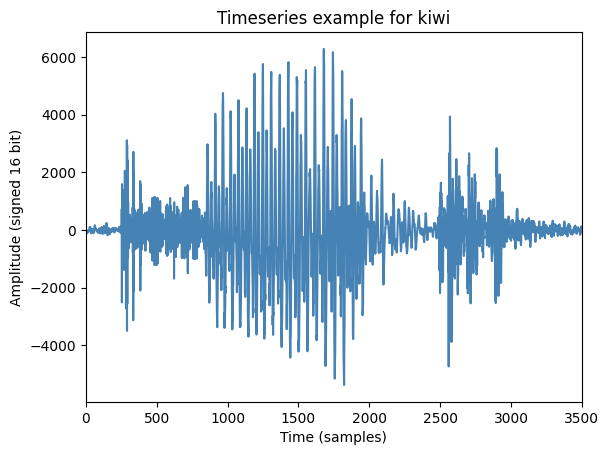

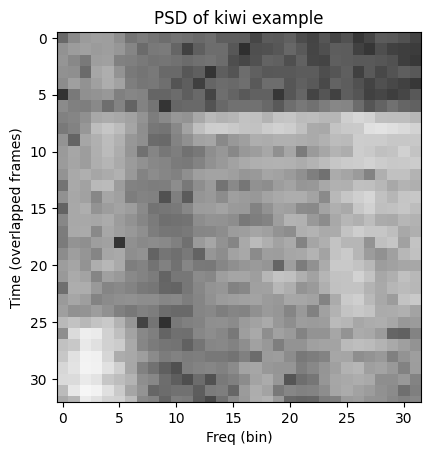

In [10]:
import matplotlib.pyplot as plt
plt.plot(data[0, :], color='steelblue')
plt.title('Timeseries example for %s'%labels[0])
plt.xlim(0, 3500)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (signed 16 bit)')
plt.figure()

# + 1 to avoid log of 0
log_freq = 20 * np.log(np.abs(stft(data[0, :])) + 1)
print(log_freq.shape)
plt.imshow(log_freq, cmap='gray', interpolation=None)
plt.xlabel('Freq (bin)')
plt.ylabel('Time (overlapped frames)')
plt.ylim(log_freq.shape[1])
plt.title('PSD of %s example'%labels[0])

Next, peak detection is applied to each FFT frame of every data file. In a [previous blog post](http://kastnerkyle.github.io/blog/2014/04/17/wavelets/), I described the use of wavelets for peak detection. Here, we will use a moving window to search for peaks instead. The primary steps to this algorithm are as follows:

1. Create a data window of length X. In this example X=9, though any window size can be used.
2. Split this window into 3 sections: left, center and right. For the 9 sample window, this will be LLLCCCRRR.
3. Apply some function (mean, median, max, min, etc) over each section of the window.
4. If the maximum value of the function over the center section is greater than the result for left or right, continue to the next check. Otherwise GOTO 6.
5. If the maximum value for f(CCC) is in the very center of the window, you have found a peak! Mark it and continue. Otherwise, go to the next step.
6. Shift the input data by one sample, and repeat the process. (data[0:9] -> data[1:10])
7. Once all data has been processed, you should have some detected peaks. Sort them in descending order by amplitude, then output the top N peaks. In this case, N=6

An implementation of this algorithm is shown below.

In [11]:
from numpy.lib.stride_tricks import as_strided

#Peak detection using the technique described here: http://kkjkok.blogspot.com/2013/12/dsp-snippets_9.html
def peakfind(x, n_peaks, l_size=3, r_size=3, c_size=3, f=np.mean):
    win_size = l_size + r_size + c_size
    shape = x.shape[:-1] + (x.shape[-1] - win_size + 1, win_size)
    strides = x.strides + (x.strides[-1],)
    xs = as_strided(x, shape=shape, strides=strides)
    def is_peak(x):
        centered = (np.argmax(x) == l_size + int(c_size/2))
        l = x[:l_size]
        c = x[l_size:l_size + c_size]
        r = x[-r_size:]
        passes = np.max(c) > np.max([f(l), f(r)])
        if centered and passes:
            return np.max(c)
        else:
            return -1
    r = np.apply_along_axis(is_peak, 1, xs)
    top = np.argsort(r, None)[::-1]
    heights = r[top[:n_peaks]]
    #Add l_size and half - 1 of center size to get to actual peak location
    top[top > -1] = top[top > -1] + l_size + int(c_size / 2.)
    return heights, top[:n_peaks]

<ipython-input-9-1f1700c8f42f>:6: DeprecationWarning: scipy.hanning is deprecated and will be removed in SciPy 2.0.0, use numpy.hanning instead
  w = scipy.hanning(fftsize + 1)[:-1]


Text(0, 0.5, 'Amplitude')

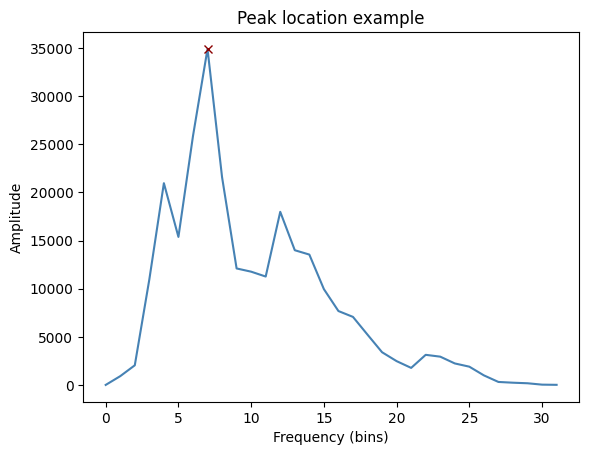

In [12]:
plot_data = np.abs(stft(data[20, :]))[15, :]
values, locs = peakfind(plot_data, n_peaks=6)
fp = locs[values > -1]
fv = values[values > -1]
plt.plot(plot_data, color='steelblue')
plt.plot(fp, fv, 'x', color='darkred')
plt.title('Peak location example')
plt.xlabel('Frequency (bins)')
plt.ylabel('Amplitude')

The peak detector does an acceptable job in detecting peaks, though it is by no means perfect. One of the limiting factors here is the length of the FFT - this peak detector is currently searching over 9 sample chunks, which is very large when the FFT size is only 64 bins! Once again, this will have a negative impact on performance.

We could set the FFT size larger, but in testing this algorithm longer FFT sizes appeared to do worse, even *with* higher overlap to maintain the same time resolution. Ultimately, this is where more advanced features would come into play.

In [13]:
#This processing (top freq peaks) only works for single speaker case... need better features for multispeaker!
#MFCC (or deep NN/automatic feature extraction) could be interesting
all_obs = []
for i in range(data.shape[0]):
    d = np.abs(stft(data[i, :]))
    n_dim = 6
    obs = np.zeros((n_dim, d.shape[0]))
    for r in range(d.shape[0]):
        _, t = peakfind(d[r, :], n_peaks=n_dim)
        obs[:, r] = t.copy()
    if i % 10 == 0:
        print("Processed obs %s" % i)
    all_obs.append(obs)

all_obs = np.atleast_3d(all_obs)

<ipython-input-9-1f1700c8f42f>:6: DeprecationWarning: scipy.hanning is deprecated and will be removed in SciPy 2.0.0, use numpy.hanning instead
  w = scipy.hanning(fftsize + 1)[:-1]


Processed obs 0
Processed obs 10
Processed obs 20
Processed obs 30
Processed obs 40
Processed obs 50
Processed obs 60
Processed obs 70
Processed obs 80
Processed obs 90
Processed obs 100


GMM-HMM Bop
-----------

An implementation of a GMM-HMM is shown below. This code is also available as a [gist](https://gist.github.com/kastnerkyle/75483d51641a0c03bf7c), and any improvements I make will show up there.

This algorithm is fairly complex, and a good summary can be seen [here, Brown](http://cs.brown.edu/research/ai/dynamics/tutorial/Documents/HiddenMarkovModels.html) and [here, Moore](http://www.autonlab.org/tutorials/hmm.html). This implementation does *not* have any Viterbi backtracking - since my only interest (for now) is in speech classification, only Baum-Welch and Forward-Backward portions of the GMM-HMM are necessary.

HMMs can do do three primary tasks:

1. State Estimation $P(S | O)$ - can be useful *if* you have prior info about what states mean and create the state probabilities yourself.
2. Path Estimation - given observations, what is the most likely "state path"? Not useful in our case, and not even implemented here!
3. Maximum Likelihood Estimation $P(O | \lambda)$ - learn the HMM parameters $\lambda$ which maximize the probability of observations. This is the primary method we will use.

To train the HMM, we use the Baum-Welch algorithm. There are many, many resources on this algorithm and I will not regurgitate here. Implementing this HMM was fairly tricky, and I highly recommend using a library unless you are interested in a "learning experience".

This code uses requires scipy 0.14 for the multivariate_normal density.

In [14]:
import scipy.stats as st
import numpy as np

class gmmhmm:
    #This class converted with modifications from https://code.google.com/p/hmm-speech-recognition/source/browse/Word.m
    def __init__(self, n_states):
        self.n_states = n_states
        self.random_state = np.random.RandomState(0)

        #Normalize random initial state
        self.prior = self._normalize(self.random_state.rand(self.n_states, 1))
        self.A = self._stochasticize(self.random_state.rand(self.n_states, self.n_states))

        self.mu = None
        self.covs = None
        self.n_dims = None

    def _forward(self, B):
        log_likelihood = 0.
        T = B.shape[1]
        alpha = np.zeros(B.shape)
        for t in range(T):
            if t == 0:
                alpha[:, t] = B[:, t] * self.prior.ravel()
            else:
                alpha[:, t] = B[:, t] * np.dot(self.A.T, alpha[:, t - 1])

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood = log_likelihood + np.log(alpha_sum)
        return log_likelihood, alpha

    def _backward(self, B):
        T = B.shape[1]
        beta = np.zeros(B.shape);

        beta[:, -1] = np.ones(B.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.A, (B[:, t + 1] * beta[:, t + 1]))
            beta[:, t] /= np.sum(beta[:, t])
        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.n_states, obs.shape[1]))
        for s in range(self.n_states):
            #Needs scipy 0.14
            np.random.seed(self.random_state.randint(1))
            B[s, :] = st.multivariate_normal.pdf(
                obs.T, mean=self.mu[:, s].T, cov=self.covs[:, :, s].T)
            #This function can (and will!) return values >> 1
            #See the discussion here for the equivalent matlab function
            #https://groups.google.com/forum/#!topic/comp.soft-sys.matlab/YksWK0T74Ak
            #Key line: "Probabilities have to be less than 1,
            #Densities can be anything, even infinite (at individual points)."
            #This is evaluating the density at individual points...
        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        #Using this _em_init function allows for less required constructor args
        if self.n_dims is None:
            self.n_dims = obs.shape[0]
        if self.mu is None:
            subset = self.random_state.choice(np.arange(self.n_dims), size=self.n_states, replace=False)
            self.mu = obs[:, subset]
        if self.covs is None:
            self.covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
            self.covs += np.diag(np.diag(np.cov(obs)))[:, :, None]
        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        B = self._state_likelihood(obs)
        T = obs.shape[1]

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.n_states, self.n_states))
        gamma = np.zeros((self.n_states, T))

        for t in range(T - 1):
            partial_sum = self.A * np.dot(alpha[:, t], (beta[:, t] * B[:, t + 1]).T)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)

        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = gamma[:, 0]
        expected_A = self._stochasticize(xi_sum)

        expected_mu = np.zeros((self.n_dims, self.n_states))
        expected_covs = np.zeros((self.n_dims, self.n_dims, self.n_states))

        gamma_state_sum = np.sum(gamma, axis=1)
        #Set zeros to 1 before dividing
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        for s in range(self.n_states):
            gamma_obs = obs * gamma[s, :]
            expected_mu[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]
            partial_covs = np.dot(gamma_obs, obs.T) / gamma_state_sum[s] - np.dot(expected_mu[:, s], expected_mu[:, s].T)
            #Symmetrize
            partial_covs = np.triu(partial_covs) + np.triu(partial_covs).T - np.diag(partial_covs)

        #Ensure positive semidefinite by adding diagonal loading
        expected_covs += .01 * np.eye(self.n_dims)[:, :, None]

        self.prior = expected_prior
        self.mu = expected_mu
        self.covs = expected_covs
        self.A = expected_A
        return log_likelihood

    def fit(self, obs, n_iter=15):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            for i in range(n_iter):
                self._em_init(obs)
                log_likelihood = self._em_step(obs)
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            for n in range(count):
                for i in range(n_iter):
                    self._em_init(obs[n, :, :])
                    log_likelihood = self._em_step(obs[n, :, :])
        return self

    def transform(self, obs):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            B = self._state_likelihood(obs)
            log_likelihood, _ = self._forward(B)
            return log_likelihood
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            out = np.zeros((count,))
            for n in range(count):
                B = self._state_likelihood(obs[n, :, :])
                log_likelihood, _ = self._forward(B)
                out[n] = log_likelihood
            return out

if __name__ == "__main__":
    rstate = np.random.RandomState(0)
    t1 = np.ones((4, 40)) + .001 * rstate.rand(4, 40)
    t1 /= t1.sum(axis=0)
    t2 = rstate.rand(*t1.shape)
    t2 /= t2.sum(axis=0)

    m1 = gmmhmm(2)
    m1.fit(t1)
    m2 = gmmhmm(2)
    m2.fit(t2)

    m1t1 = m1.transform(t1)
    m2t1 = m2.transform(t1)
    print("Likelihoods for test set 1")
    print("M1:", m1t1)
    print("M2:", m2t1)
    print("Prediction for test set 1")
    print("Model", np.argmax([m1t1, m2t1]) + 1)
    print()

    m1t2 = m1.transform(t2)
    m2t2 = m2.transform(t2)
    print("Likelihoods for test set 2")
    print("M1:", m1t2)
    print("M2:", m2t2)
    print("Prediction for test set 2")
    print("Model", np.argmax([m1t2, m2t2]) + 1)

Likelihoods for test set 1
M1: 221.38828575112734
M2: 165.27280230776495
Prediction for test set 1
Model 1

Likelihoods for test set 2
M1: 33.19459421485196
M2: 59.152747530529986
Prediction for test set 2
Model 2


Still Peaking
-------------

Once the peaks are detected for each frame, we have a 3 dimensional numpy array of size [numdatafiles, numpeaks, numframes] - in this case [105, 6, 216]. It is important that the observations be normalized in order to form probabilities, since the HMM expects to be trained on state probabilities. What does this mean?

For each sample, we have extracted a number of frames over time, and each frame has its own set of peaks. We divide each frame by the sum of all peaks in the frame (axis 0 of all_obs[n], or axis 1 of all_obs), and form a "state probability" for each frame in our dataset. In essence, we are creating 6 states, where the highest peak in a frame is state 1, second highest state 2, etc. for each FFT frame.

This representation shows the "spread" of the peaks - if all the peaks are close together, each one will have about the same probability, while peaks that are in a more unique distribution should take on a more unique fingerprint. An extreme case would be 3 low frequency peaks, and 3 high - this would result in very low state probabilities for the low frequency peaks, and very high state probabilities for the high frequency peaks. Since the HMM attempts to learn transition probabilities between frames, this is a decent way to represent speech for HMMs.

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(test_size=0.1, random_state=0)

for n,i in enumerate(all_obs):
    all_obs[n] /= all_obs[n].sum(axis=0)

for train_index, test_index in sss.split(all_obs, all_labels):
    X_train, X_test = all_obs[train_index, ...], all_obs[test_index, ...]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
print('Size of training matrix:', X_train.shape)
print('Size of testing matrix:', X_test.shape)

Size of training matrix: (94, 6, 216)
Size of testing matrix: (11, 6, 216)


To predict words, we need to train 7 separate GMM-HMM models, one for each word. We will then feed the features for a test sample into each, choosing the word associated with the GMM-HMM having the highest output likelihood. This maximum likelihood estimate is our best guess for what word was spoken.

In [19]:
ys = set(all_labels)
ms = [gmmhmm(6) for y in ys]
_ = [m.fit(X_train[y_train == y, :, :]) for m, y in zip(ms, ys)]
ps = [m.transform(X_test) for m in ms]
res = np.vstack(ps)
predicted_labels = np.argmax(res, axis=0)
missed = (predicted_labels != y_test)
print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))

Test accuracy: 72.73 percent


It seems that this classifier does decently. Let's look at a confusion matrix for what words were incorrect, to see if there is any unusual pattern in the misclassifications.

<ipython-input-20-d7a918d2c203>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([" "] + [l[:2] for l in spoken])
<ipython-input-20-d7a918d2c203>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([" "] + spoken)


Text(0.5, 0, 'Predicted label')

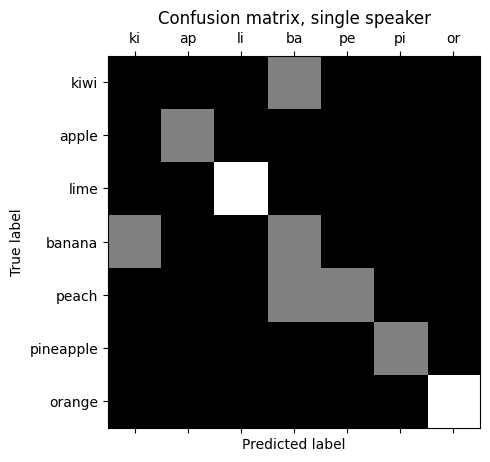

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.matshow(cm, cmap='gray')
ax = plt.gca()
_ = ax.set_xticklabels([" "] + [l[:2] for l in spoken])
_ = ax.set_yticklabels([" "] + spoken)
plt.title('Confusion matrix, single speaker')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Though the confusion matrix doesn't provide much insight, it is good to see a "real" example of using HMMs to do single speaker speech recognition.